In [84]:
import numpy as np 
import pandas as pd
from scipy import stats
import math
from math import cos, asin, sqrt, radians
import datetime
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve, KFold, train_test_split
from sklearn import naive_bayes
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import f1_score, roc_curve, roc_auc_score ,confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cluster import KMeans, AgglomerativeClustering

from xgboost import XGBClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

RANDOM_SEED = 6 

/kaggle/input/ml_sample_submission.csv
/kaggle/input/ml_test.csv
/kaggle/input/ml_train.csv


In [85]:
features_df = pd.read_csv("/kaggle/input/ml_train.csv", index_col="tripid")
test_features_df = pd.read_csv("/kaggle/input/ml_test.csv", index_col="tripid")
submission_df = pd.read_csv("/kaggle/input/ml_sample_submission.csv", index_col="tripid")

In [86]:
features_df["label"] = features_df["label"].map({"incorrect": 0, "correct":1})

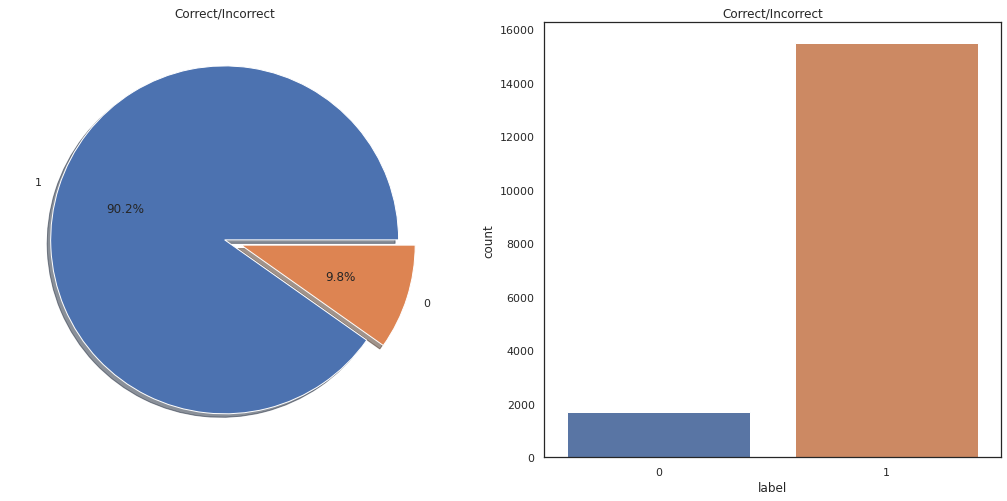

In [87]:
f,ax=plt.subplots(1,2,figsize=(18,8))
features_df['label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Correct/Incorrect')
ax[0].set_ylabel('')
sns.countplot('label',data=features_df,ax=ax[1])
ax[1].set_title('Correct/Incorrect')
plt.show()

In [88]:
features_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
count,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17176.000000,17176.000000,17176.000000,17176.000000,17039.000000,17176.000000
mean,13.719651,1702.858077,629.074231,32.057666,112.466832,6.965499,79.998389,6.968587,79.997534,312.655466,0.902131
std,98.975052,8120.160818,8063.260669,465.483573,442.054812,0.210760,0.243384,0.378669,0.359648,605.300565,0.297146
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000,0.000000
25%,10.500000,548.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.515000,1.000000
50%,10.500000,1009.500000,123.000000,0.116600,73.000000,6.914105,79.898600,6.916160,79.899100,211.180000,1.000000
75%,10.500000,1803.000000,351.000000,14.341800,144.000000,7.043057,79.956600,7.047195,79.960225,366.465000,1.000000
max,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000,1.000000


In [89]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17176 entries, 189123628 to 213817296
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16974 non-null  float64
 1   duration                   16974 non-null  float64
 2   meter_waiting              16974 non-null  float64
 3   meter_waiting_fare         16974 non-null  float64
 4   meter_waiting_till_pickup  16974 non-null  float64
 5   pickup_time                17176 non-null  object 
 6   drop_time                  17176 non-null  object 
 7   pick_lat                   17176 non-null  float64
 8   pick_lon                   17176 non-null  float64
 9   drop_lat                   17176 non-null  float64
 10  drop_lon                   17176 non-null  float64
 11  fare                       17039 non-null  float64
 12  label                      17176 non-null  int64  
dtypes: float64(10), int64(1), object(2

In [90]:
test_features_df.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,11.088095,1541.590485,508.502099,24.671655,119.863106,6.969246,80.008728,6.970008,80.010145,293.278057
std,5.359602,5952.458574,5784.005855,333.515641,793.233190,0.217809,0.251873,0.218826,0.252229,436.730282
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.943130,79.817700,5.936600,79.818000,0.000000
25%,10.500000,540.000000,30.000000,0.000000,26.000000,6.864810,79.871600,6.864950,79.871300,126.077500
50%,10.500000,982.500000,116.000000,0.000000,72.000000,6.913605,79.900500,6.915460,79.902250,203.950000
75%,10.500000,1723.000000,336.250000,11.744200,138.000000,7.068875,79.963225,7.073505,79.967825,344.075000
max,160.500000,447230.000000,446934.000000,25760.361800,55571.000000,8.425010,80.776400,8.421730,80.805500,26844.330000


In [91]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8576 entries, 213284604 to 222860703
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            8576 non-null   float64
 1   duration                   8576 non-null   int64  
 2   meter_waiting              8576 non-null   int64  
 3   meter_waiting_fare         8576 non-null   float64
 4   meter_waiting_till_pickup  8576 non-null   int64  
 5   pickup_time                8576 non-null   object 
 6   drop_time                  8576 non-null   object 
 7   pick_lat                   8576 non-null   float64
 8   pick_lon                   8576 non-null   float64
 9   drop_lat                   8576 non-null   float64
 10  drop_lon                   8576 non-null   float64
 11  fare                       8576 non-null   float64
dtypes: float64(7), int64(3), object(2)
memory usage: 871.0+ KB


In [92]:
def clean_df(df):
    #remove locations out of SriLanka
    return df[(df.drop_lat < 10)]

In [93]:
features_df = clean_df(features_df)

In [94]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

In [95]:
#Outliers_to_drop = detect_outliers(features_df,1,["duration","meter_waiting","meter_waiting_fare","meter_waiting_till_pickup","fare","pick_lat","pick_lon","drop_lat","drop_lon"])

Drop outliers found

In [96]:
#features_df = features_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


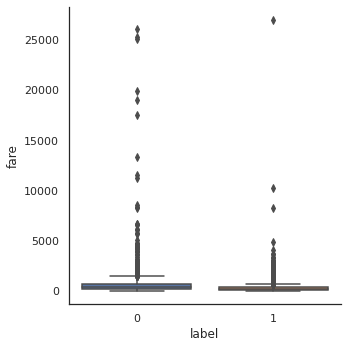

In [97]:
g = sns.factorplot(x="label", y = "fare",data = features_df, kind="box")

Fill missing values with the mean of each label category

In [98]:
p_mean = features_df[features_df['label']==1]['fare'].mean()
n_mean = features_df[features_df['label']==0]['fare'].mean()
p_mask = (features_df['label']==1)
n_mask = (features_df['label']==0)

features_df.loc[p_mask,'fare'] = features_df.loc[p_mask,'fare'].fillna(p_mean)
features_df.loc[n_mask,'fare'] = features_df.loc[n_mask,'fare'].fillna(n_mean)

In [99]:
p_mean = features_df[features_df['label']==1]['meter_waiting'].mean()
n_mean = features_df[features_df['label']==0]['meter_waiting'].mean()
p_mask = (features_df['label']==1)
n_mask = (features_df['label']==0)

features_df.loc[p_mask,'meter_waiting'] = features_df.loc[p_mask,'meter_waiting'].fillna(p_mean)
features_df.loc[n_mask,'meter_waiting'] = features_df.loc[n_mask,'meter_waiting'].fillna(n_mean)

In [100]:
p_mean = features_df[features_df['label']==1]['meter_waiting_fare'].mean()
n_mean = features_df[features_df['label']==0]['meter_waiting_fare'].mean()
p_mask = (features_df['label']==1)
n_mask = (features_df['label']==0)

features_df.loc[p_mask,'meter_waiting_fare'] = features_df.loc[p_mask,'meter_waiting_fare'].fillna(p_mean)
features_df.loc[n_mask,'meter_waiting_fare'] = features_df.loc[n_mask,'meter_waiting_fare'].fillna(n_mean)

In [101]:
p_mean = features_df[features_df['label']==1]['additional_fare'].mean()
n_mean = features_df[features_df['label']==0]['additional_fare'].mean()
p_mask = (features_df['label']==1)
n_mask = (features_df['label']==0)

features_df.loc[p_mask,'additional_fare'] = features_df.loc[p_mask,'additional_fare'].fillna(p_mean)
features_df.loc[n_mask,'additional_fare'] = features_df.loc[n_mask,'additional_fare'].fillna(n_mean)

In [102]:
p_mean = features_df[features_df['label']==1]['meter_waiting_till_pickup'].mean()
n_mean = features_df[features_df['label']==0]['meter_waiting_till_pickup'].mean()
p_mask = (features_df['label']==1)
n_mask = (features_df['label']==0)

features_df.loc[p_mask,'meter_waiting_till_pickup'] = features_df.loc[p_mask,'meter_waiting_till_pickup'].fillna(p_mean)
features_df.loc[n_mask,'meter_waiting_till_pickup'] = features_df.loc[n_mask,'meter_waiting_till_pickup'].fillna(n_mean)

In [103]:
p_mean = features_df[features_df['label']==1]['duration'].mean()
n_mean = features_df[features_df['label']==0]['duration'].mean()
p_mask = (features_df['label']==1)
n_mask = (features_df['label']==0)

features_df.loc[p_mask,'duration'] = features_df.loc[p_mask,'duration'].fillna(p_mean)
features_df.loc[n_mask,'duration'] = features_df.loc[n_mask,'duration'].fillna(n_mean)

Convert seconds to minutes in time features

In [104]:
features_df['meter_waiting'] = features_df['meter_waiting']/60
features_df['meter_waiting_till_pickup'] = features_df['meter_waiting_till_pickup']/60
features_df['duration'] = features_df['duration']/60

test_features_df['meter_waiting'] = test_features_df['meter_waiting']/60
test_features_df['meter_waiting_till_pickup'] = test_features_df['meter_waiting_till_pickup']/60
test_features_df['duration'] = test_features_df['duration']/60

In [105]:
train_df = features_df.copy()
test_df = test_features_df.copy()

In [106]:
# To Compute Haversine distance
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

    
def sphere_dist_bear(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

def radian_conv(degree):
    """
    Return radian.
    """
    return  np.radians(degree)    

In [107]:
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_time'] = pd.to_datetime(dataset['pickup_time'],format="%m/%d/%Y %H:%M")
    dataset['drop_time'] = pd.to_datetime(dataset['drop_time'],format="%m/%d/%Y %H:%M")
    dataset['runtime'] = (dataset['drop_time']-dataset['pickup_time']).astype('timedelta64[m]')
    
    dataset['hour'] = dataset.drop_time.dt.hour
    dataset['day'] = dataset.pickup_time.dt.day
    dataset['month'] = dataset.pickup_time.dt.month
    dataset['weekday'] = dataset.pickup_time.dt.weekday
    dataset['year'] = dataset.pickup_time.dt.year
    
    return dataset

Get distance using pickup_location and dopoff_location



And convert pick_up time and etc to datetime data type

In [108]:
train_df = add_datetime_info(train_df)
train_df['distance'] = sphere_dist(train_df['pick_lat'], train_df['pick_lon'], 
                                   train_df['drop_lat'] , train_df['drop_lon']) 

train_df['bearing'] = sphere_dist_bear(train_df['pick_lat'], train_df['pick_lon'], 
                                   train_df['drop_lat'] , train_df['drop_lon'])                                    
train_df['pick_lat'] = radian_conv(train_df['pick_lat'])
train_df['pick_lon'] = radian_conv(train_df['pick_lon'])
train_df['drop_lat'] = radian_conv(train_df['drop_lat'])
train_df['drop_lon'] = radian_conv(train_df['drop_lon'])

In [109]:
test_df = add_datetime_info(test_df)
test_df['distance'] = sphere_dist(test_df['pick_lat'], test_df['pick_lon'], 
                                   test_df['drop_lat'] , test_df['drop_lon']) 

test_df['bearing'] = sphere_dist_bear(test_df['pick_lat'], test_df['pick_lon'], 
                                   test_df['drop_lat'] , test_df['drop_lon'])                                    
test_df['pick_lat'] = radian_conv(test_df['pick_lat'])
test_df['pick_lon'] = radian_conv(test_df['pick_lon'])
test_df['drop_lat'] = radian_conv(test_df['drop_lat'])
test_df['drop_lon'] = radian_conv(test_df['drop_lon'])

In [126]:
def clustering(dataset):
    pickup_clusters = KMeans(n_clusters=5, random_state=0).fit(dataset.filter(regex='pick_l'))
    dropoff_clusters = KMeans(n_clusters=4, random_state=0).fit(dataset.filter(regex='drop_l'))
    dataset['pickup_cluster'] = pickup_clusters.labels_
    dataset['dropoff_cluster'] = dropoff_clusters.labels_ 
    return dataset

In [127]:
train_len = len(train_df)
dataset =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)
dataset = clustering(dataset)
train_df = dataset[:train_len]
test_df = dataset[train_len:]
test_df= test_df.drop(columns=['label'])

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


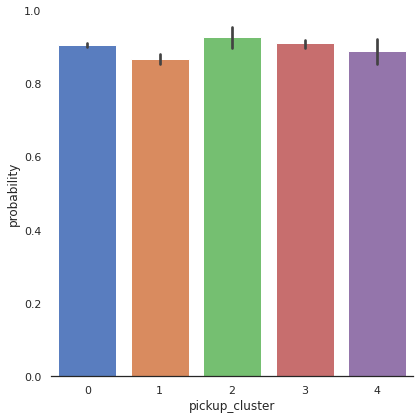

In [128]:
g = sns.factorplot(x="pickup_cluster",y="label",data=dataset,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("probability")

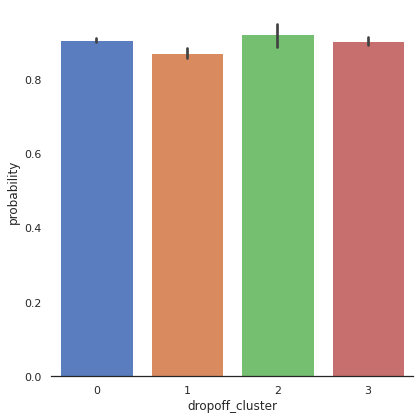

In [129]:
g = sns.factorplot(x="dropoff_cluster",y="label",data=dataset,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("probability")

Create new features using existing features

In [110]:
train_df['waiting_percent']=train_df['meter_waiting']/train_df['duration']
train_df['fare_per_waiting']=train_df['meter_waiting_fare']/train_df['meter_waiting']
train_df['additional_fare_per_duration']=train_df['additional_fare']/train_df['duration']

test_df['waiting_percent']=test_df['meter_waiting']/test_df['duration']
test_df['fare_per_waiting']=test_df['meter_waiting_fare']/test_df['meter_waiting']
test_df['additional_fare_per_duration']=test_df['additional_fare']/test_df['duration']

In [111]:
train_df['distance_fare_per_distance']=(train_df['fare']-train_df['additional_fare']
                              -train_df['meter_waiting_fare'])/train_df['distance']
train_df['distance_fare_per_distance'] = train_df['distance_fare_per_distance'].clip(lower=0)
train_df['distance_fare_per_distance'] = train_df['distance_fare_per_distance'].replace(np.inf, np.nan)

test_df['distance_fare_per_distance']=(test_df['fare']-test_df['additional_fare']
                              -test_df['meter_waiting_fare'])/test_df['distance']
test_df['distance_fare_per_distance'] = test_df['distance_fare_per_distance'].clip(lower=0)
test_df['distance_fare_per_distance'] = test_df['distance_fare_per_distance'].replace(np.inf, np.nan)

In [112]:
train_df['fare_per_distance']=(train_df['fare'])/train_df['distance']
train_df['fare_per_distance'] = train_df['fare_per_distance'].replace(np.inf, np.nan)

test_df['fare_per_distance']=(test_df['fare'])/test_df['distance']
test_df['fare_per_distance'] = test_df['fare_per_distance'].replace(np.inf, np.nan)

In [113]:
train_df['distance_fare']=train_df['fare']-train_df['additional_fare']-train_df['meter_waiting_fare']
train_df['distance_fare']=train_df['distance_fare'].clip(lower=0)

test_df['distance_fare']=test_df['fare']-test_df['additional_fare']-test_df['meter_waiting_fare']
test_df['distance_fare']=test_df['distance_fare'].clip(lower=0)

In [114]:
train_df['distance_fare_per_fare'] = (train_df['distance_fare'])/train_df['fare']
train_df['distance_fare_per_fare'] = train_df['distance_fare_per_fare'].replace(np.nan, 0)

test_df['distance_fare_per_fare'] = (test_df['distance_fare'])/test_df['fare']
test_df['distance_fare_per_fare'] = test_df['distance_fare_per_fare'].replace(np.nan, 0)

In [115]:
train_df['duration_per_fare'] = (train_df['runtime']-train_df['meter_waiting'])/train_df['fare']
train_df['duration_per_fare'] = train_df['duration_per_fare'].clip(lower=0)
train_df['duration_per_fare'] = train_df['duration_per_fare'].replace(np.inf, 0)
train_df['duration_per_fare'] = train_df['duration_per_fare'].replace(np.nan, 0)

test_df['duration_per_fare'] = (test_df['runtime']-test_df['meter_waiting'])/test_df['fare']
test_df['duration_per_fare'] = test_df['duration_per_fare'].clip(lower=0)
test_df['duration_per_fare'] = test_df['duration_per_fare'].replace(np.inf, 0)
test_df['duration_per_fare'] = test_df['duration_per_fare'].replace(np.nan, 0)

In [116]:
train_df['runtime_per_fare'] = (train_df['runtime'])/train_df['fare']
train_df['runtime_per_fare'] = train_df['runtime_per_fare'].replace(np.inf, 0)
train_df['runtime_per_fare'] = train_df['runtime_per_fare'].replace(np.nan, 0)

test_df['runtime_per_fare'] = (test_df['runtime'])/test_df['fare']
test_df['runtime_per_fare'] = test_df['runtime_per_fare'].replace(np.inf, 0)
test_df['runtime_per_fare'] = test_df['runtime_per_fare'].replace(np.nan, 0)

In [117]:
train_df['travel_time'] = train_df['runtime'] - train_df['meter_waiting']
train_df['travel_time']=train_df['travel_time'].clip(lower=0)

test_df['travel_time'] = test_df['runtime'] - test_df['meter_waiting']
test_df['travel_time'] = test_df['travel_time'].clip(lower=0)

In [118]:
train_df['travel_time_per_distance']=train_df['travel_time']/train_df['distance']
train_df['travel_time_per_distance'] = train_df['travel_time_per_distance'].replace(np.inf, np.nan)

test_df['travel_time_per_distance']=test_df['travel_time']/test_df['distance']
test_df['travel_time_per_distance'] = test_df['travel_time_per_distance'].replace(np.inf, np.nan)

In [119]:
def isRushHours(x):
    if((x>=16) & (x<=20)):
        return 1
    else:
        return 0
train_df["IS_RUSH_HOURS"]=train_df["hour"].apply(lambda x:isRushHours(x))
test_df["IS_RUSH_HOURS"]=test_df["hour"].apply(lambda x:isRushHours(x))

In [120]:
def isNightHours(x):
    if((x>=20) | (x<=6)):
        return 1
    else:
        return 0
train_df["IS_NIGHT_HOURS"]=train_df["hour"].apply(lambda x:isNightHours(x))
test_df["IS_NIGHT_HOURS"]=test_df["hour"].apply(lambda x:isNightHours(x))

In [121]:
def isWeekEnd(x):
    if((x==5) | (x==6)):
        return 1
    else:
        return 0
train_df["IS_WEEK_END"]=train_df['weekday'].apply(lambda x:isWeekEnd(x))
test_df["IS_WEEK_END"]=test_df['weekday'].apply(lambda x:isWeekEnd(x))

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


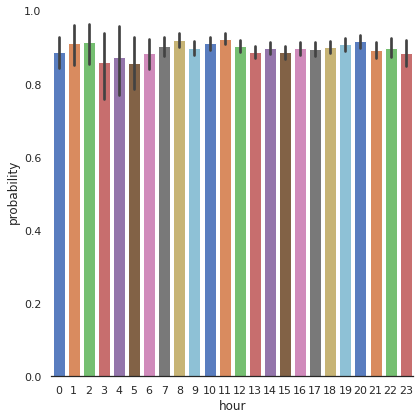

In [122]:
g = sns.factorplot(x="hour",y="label",data=train_df,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("probability")

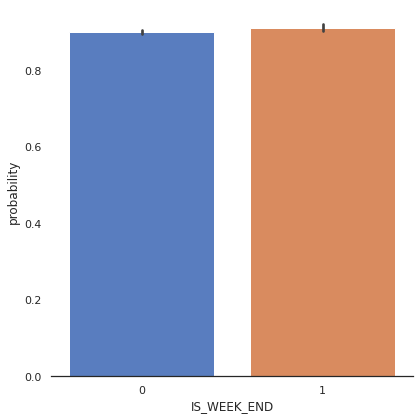

In [123]:
g = sns.factorplot(x="IS_WEEK_END",y="label",data=train_df,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("probability")

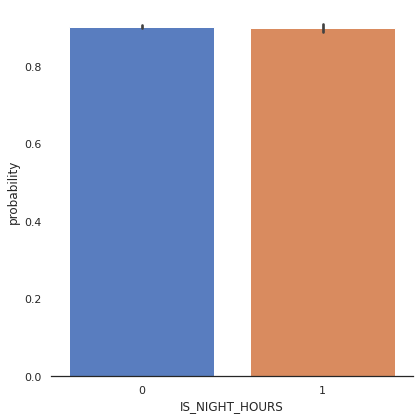

In [124]:
g = sns.factorplot(x="IS_NIGHT_HOURS",y="label",data=train_df,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("probability")

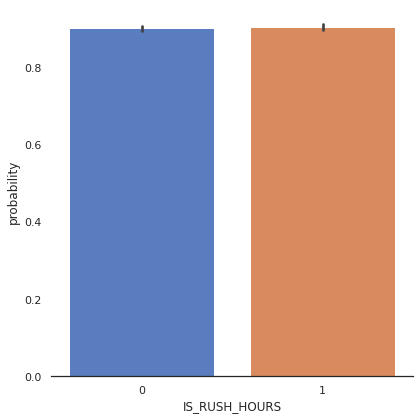

In [125]:
g = sns.factorplot(x="IS_RUSH_HOURS",y="label",data=train_df,kind="bar", size = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("probability")

In [130]:
train_df.drop(columns=['waiting_percent',
                       'distance_fare_per_fare',
                       'fare_per_distance',
                       #'fare',
                       #'fare_per_waiting',
                       'pickup_time', 'drop_time',
                       #'additional_fare',
                       'duration',
                       'meter_waiting',
                       'meter_waiting_fare',
                       'meter_waiting_till_pickup',
                       'year',
                       'month',
                       'day',
                       #'hour',
                       'bearing',
                       'weekday',
                       'distance_fare',
                       #"runtime",
                       #'distance_fare_per_distance',
                       #'travel_time_per_distance',
                       #'runtime',
                       #'distance',
                       'dropoff_cluster','pickup_cluster',
                       #'duration_per_fare',
                       'pick_lat','pick_lon','drop_lat','drop_lon',
                       #'distance',
                      'IS_RUSH_HOURS',
                      "IS_NIGHT_HOURS",
                      "IS_WEEK_END",
                      #"travel_time"
                      ], inplace=True)

y = train_df['label']
train_df = train_df.drop(columns=['label'])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [131]:
test_df.drop(columns=['waiting_percent',
                      'distance_fare_per_fare',
                      'fare_per_distance',
                      #'fare',
                       #'fare_per_waiting',
                       'pickup_time', 'drop_time',
                       #'additional_fare',
                       'duration',
                       'meter_waiting',
                       'meter_waiting_fare',
                       'meter_waiting_till_pickup',
                       'year',
                       'month',
                       'day',
                       #'hour',
                      #'runtime',
                       'bearing',
                       'weekday',
                       'distance_fare',
                      #'distance_fare_per_distance',
                       #'duration_per_distance',
                      #'travel_time_per_fare',
                       #'runtime',
                       #'distance',
                       'dropoff_cluster','pickup_cluster',
                       'pick_lat','pick_lon','drop_lat','drop_lon',
                       'IS_RUSH_HOURS',
                       "IS_NIGHT_HOURS",
                       "IS_WEEK_END",
                       #"travel_time"
                      ], inplace=True)

Get correalation matrix among feaures to find highly correlated featues

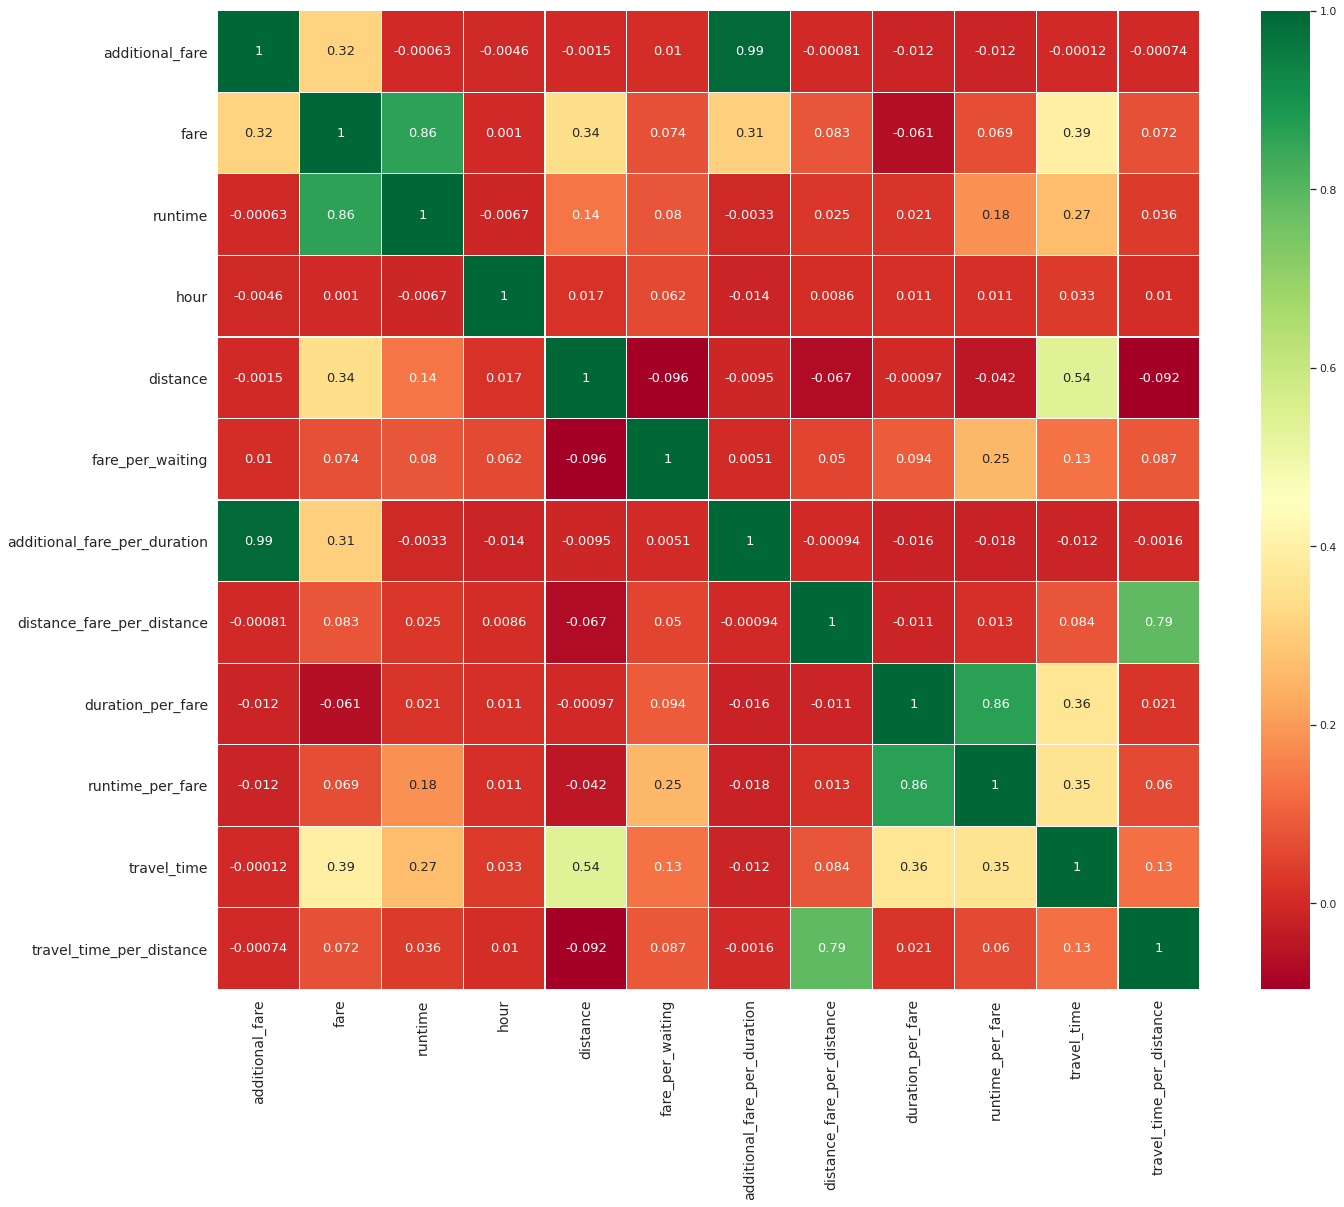

In [132]:
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':13})
fig=plt.gcf()
fig.set_size_inches(22,18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [133]:
train_df= train_df.fillna(train_df.mean())
test_df= test_df.fillna(train_df.mean())

In [ ]:
#scaler = MinMaxScaler()
#train_df = scaler.fit_transform(train_df)
#test_df = scaler.transform(test_df)

Get the feature importance

In [134]:
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(train_df,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_df.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(10,'Score'))

                           Specs         Score
7     distance_fare_per_distance  1.000441e+07
1                           fare  7.182905e+05
2                        runtime  1.373360e+05
6   additional_fare_per_duration  1.174652e+05
11      travel_time_per_distance  2.854269e+04
0                additional_fare  2.189618e+04
10                   travel_time  2.471263e+03
4                       distance  3.229577e+01
5               fare_per_waiting  1.991042e+01
9               runtime_per_fare  4.902043e+00


**------------------Modeling----------------------**

In [135]:
kfold = StratifiedKFold(n_splits=10)

In [ ]:
example_params = {
        #'n_estimators': 100,
        #'max_depth': 5,
        #'random_state': 13
    }

#method for k fold cross validation with oversampling
def score_model(model, params, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=10, random_state=42)

    smoter = SMOTE(random_state=42)
    
    scores = []

    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = f1_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
    return np.array(scores)

In [136]:
# Modeling step Test differents algorithms 
random_state = 2

classifiers = []
classifiers.append(XGBClassifier())
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(RidgeClassifier())
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(naive_bayes.BernoulliNB())
classifiers.append(naive_bayes.GaussianNB())

cv_results = []
for classifier in classifiers :
    #cross validation without oversampling
    cv_results.append(cross_val_score(classifier, train_df, y = y, scoring = 'f1_macro', cv = kfold, n_jobs=4))
    #cross validation with oversampling
    #cv_results.append(score_model(classifier, example_params, cv=None))  

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["XGBoost","SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees", "RidgeRegression","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","BNB","GNB"]})

In [137]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.865773,0.024810,XGBoost
1,0.475465,0.002395,SVC
2,0.809739,0.028098,DecisionTree
3,0.810122,0.028755,AdaBoost
4,0.868697,0.025957,RandomForest
5,0.863129,0.025034,ExtraTrees
6,0.522226,0.017950,RidgeRegression
7,0.859498,0.025207,GradientBoosting
8,0.761675,0.105410,MultipleLayerPerceptron
9,0.800275,0.016471,KNeighboors


Choose the best forming models and do hyper-parameter tuning

Here hyper-parameter tuning done for best 4 algorithms selected from above cross validation step

In [138]:
XGBC = XGBClassifier()
xgbc_param_grid = {
    "learning_rate"    : [0.1],
    "max_depth"        : [3,5],
    "n_estimators"  : [200,250],
    'booster': ['dart'],
    'rate_drop': [0.7],
    'skip_drop': [0.8]
    }
#testing for upsampling
model = Pipeline([
        ('sampling', SMOTE()),
        ('classification', XGBC)
    ])
gsXGBC = GridSearchCV(XGBC,param_grid =xgbc_param_grid, cv=kfold, scoring='f1', n_jobs= 4, verbose = 1)

gsXGBC.fit(train_df,y)

XGBC_best = gsXGBC.best_estimator_

gsXGBC.best_score_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  4.6min finished


0.9770206071085055

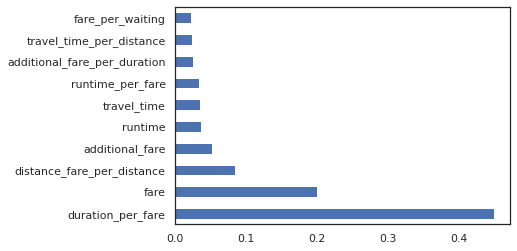

In [139]:
feat_importances = pd.Series(XGBC_best.feature_importances_, index=train_df.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [140]:
RFC = RandomForestClassifier()
rfc_param_grid = {
   'max_depth': [50],
   'n_estimators': [100]
    }

gsRFC = GridSearchCV(RFC,param_grid =rfc_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsRFC.fit(train_df,y)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   22.5s finished


0.9767158298572142

In [141]:
ETC = ExtraTreesClassifier()
etc_param_grid = {
   'max_depth': [50,40,30],
   'n_estimators': [150,200, 250]
    }

gsETC = GridSearchCV(ETC,param_grid =etc_param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gsETC.fit(train_df,y)

ETC_best = gsETC.best_estimator_

gsETC.best_score_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  2.0min finished


0.9764368843254347

In [ ]:
GBC = GradientBoostingClassifier()
gbc_param_grid = {
     'n_estimators': [50,100,150], 
     'max_depth': [3,4,5],
  
    }

gsGBC = GridSearchCV(GBC,param_grid =gbc_param_grid, cv=kfold, scoring="f1_macro", n_jobs= 4, verbose = 1)

gsGBC.fit(train_df,y)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Ensemble hyper-paramter tuned models to get a voting classifier

In [144]:
votingC = VotingClassifier(estimators=[('xgbc', XGBC_best), ('rfc', RFC_best), ('etc', ETC_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(train_df, y)

predicts_voting = votingC.predict(test_df)
submission_df["prediction"] = predicts_voting

#Submission from ensembled models
submission_df.to_csv('submission_voting.csv', index=True)

In [145]:
XGBC_f = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=175,booster='dart',rate_drop=0.7,skip_drop=0.8)
XGBC_f.fit(train_df, y)

predicts_xgbc = XGBC_f.predict(test_df)
submission_df["prediction"] = predicts_xgbc

#submission from hyper-parameter tuned xgboost classifier
submission_df.to_csv('submission_xgbc.csv', index=True)